In [1]:
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ndcg_score
from torch.nn.functional import mse_loss
from src.utils import read_qrels, ECE_Calculator

In [2]:
def plot_reliability_diagrams(predictions, labels):
    
    max_val = 3
    num_bins = 20

    # equally spaced ECE
    ece_cal = ECE_Calculator(predictions.squeeze(), labels.squeeze(), n_bins=num_bins, mode="equal_spaced")
    ece_val = ece_cal.calculate()
    x, y, p, e = ece_cal.bin_confidence, ece_cal.bin_truth, ece_cal.bin_prob, ece_cal.bin_ece
    e = [x.item() for x in e]
    left_margins, right_margins = ece_cal.bin_lowers, ece_cal.bin_uppers
    widths = [right - left for left, right in zip(left_margins, right_margins)]
    
    fig, ax1 = plt.subplots()

    ax1.set_xlabel("avg. conf in bin")
    ax1.set_ylabel("avg. truth in bin", color="r")
    
    ax1.plot(range(0, max_val + 1), range(0, max_val + 1), label="ideal", linestyle="--", color="gray")
    # ax1.plot(x, y, marker='+', color='r', markerfacecolor='none', markeredgecolor='r', ms=15)
    ax1.plot(x, y, marker='+', color='black', ms=15)
    ax1.bar(left_margins, y, width=widths, align='edge', color='red', edgecolor='black', alpha=0.5)
    ax1.tick_params(axis='y', labelcolor='r')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylim(0, 0.30)
    ax2.set_ylabel("ECE per bin", color="b")
    ax2.plot(x, e, marker='.', color='b', markerfacecolor='none', markeredgecolor='b', ms=15)
    ax2.tick_params(axis='y', labelcolor='b')
    
    fig.suptitle(f"ECE={ece_val:.3f}")
    plt.show()

    label_ece = []
    unique_labels = torch.unique(labels.squeeze()).tolist()
    for label in unique_labels:
        confidences_of_label = predictions[labels == label]
        reformatted_labels = torch.full_like(confidences_of_label, label)
        ece_cal = ECE_Calculator(
            confidences_of_label,
            reformatted_labels,
            num_bins, "equal_spaced")
        plt.subplot(2, 2, label+1)
        plt.xlim(0, max_val)
        ece_val = ece_cal.calculate()
        label_ece.append(ece_val)
        plt.title(f'Label={label}, ECE={ece_val:.3f}', y=1.0, pad=-14)
        x, y, p, e = ece_cal.bin_confidence, ece_cal.bin_truth, ece_cal.bin_prob, ece_cal.bin_ece
        left_margins, right_margins = ece_cal.bin_lowers, ece_cal.bin_uppers
        widths = [right - left for left, right in zip(left_margins, right_margins)]
        plt.ylim(0, 1)
        plt.bar(left_margins, p, width=widths, align='edge', color='red', edgecolor='black', alpha=0.5)
    plt.suptitle(f'CB-ECE={np.mean(label_ece):.3f}')    
    # plt.tight_layout()
    plt.show()

In [3]:
trec22_qrels = read_qrels("msmarco-passage-v2/trec-dl-2022/judged")

In [4]:
def calculate_metrics(results, qrels):
    
    ndcg_per_query = {}
    all_scores, all_labels = [], []
    
    for qid, lst in results.items():
        if qid in qrels:
            scores, labels = [], []
            for x in lst:
                scores.append(x[1])
                labels.append(qrels[qid][x[0]])
            ndcg = ndcg_score(np.asarray([labels]), np.asarray([scores]))
            all_scores += scores
            all_labels += labels
            ndcg_per_query[qid] = ndcg

    all_scores = torch.tensor(np.asarray(all_scores))
    all_labels = torch.tensor(np.asarray(all_labels))
    print(f"MSE: {mse_loss(all_scores, all_labels).item():.3f}")
    print(f"nDCG: {np.mean([x for x in ndcg_per_query.values()]):.3f}", len(ndcg_per_query))
    plot_reliability_diagrams(all_scores, all_labels)

MSE: 1.573
nDCG: 0.802 67


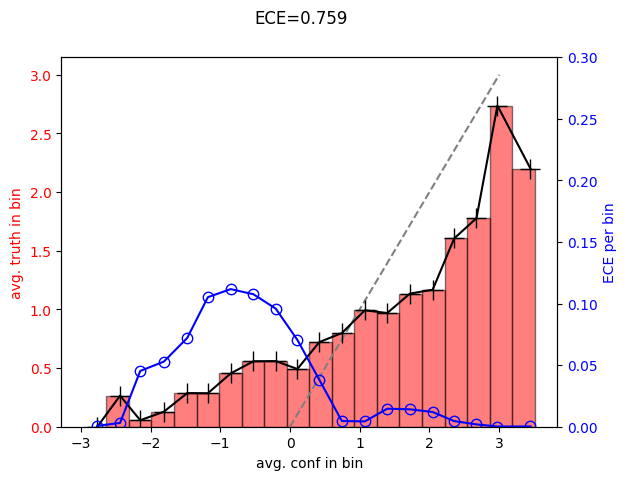

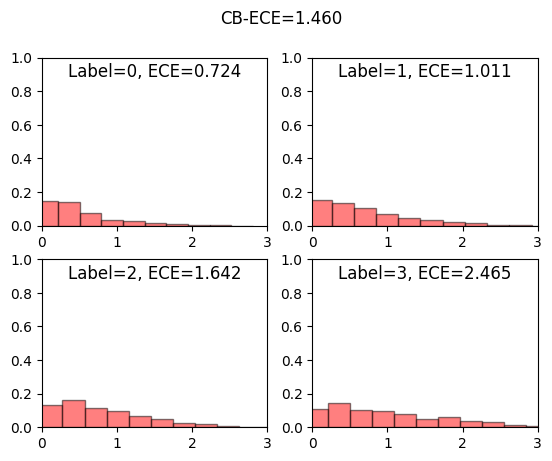

In [5]:
results_path = "../pygaggle/calibration-exp/scores/rankllama-v1-7b-lora-passage/marcov2-results.trec.pkl"
results = pickle.load(open(results_path, "rb"))
calculate_metrics(results, trec22_qrels)

MSE: 0.839
nDCG: 0.816 67


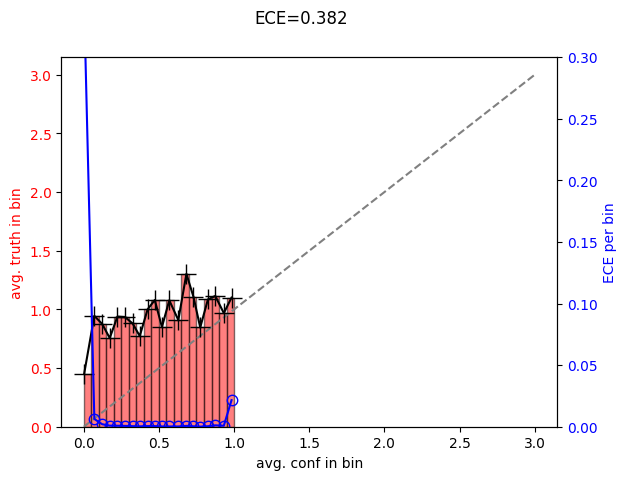

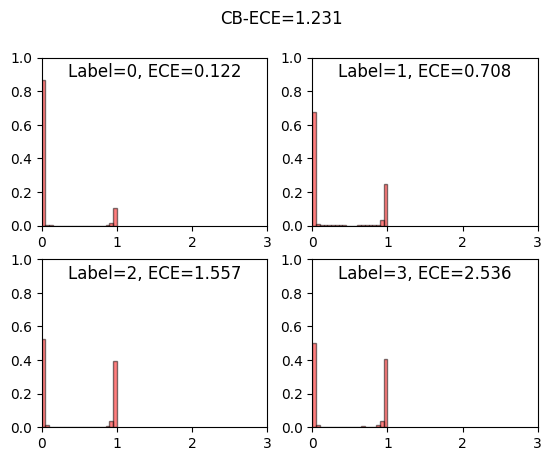

In [6]:
results_path = "../pygaggle/calibration-exp/scores/monobert-large-msmarco/marcov2-results.trec.pkl"
results = pickle.load(open(results_path, "rb"))
calculate_metrics(results, trec22_qrels)

MSE: 0.739
nDCG: 0.827 67


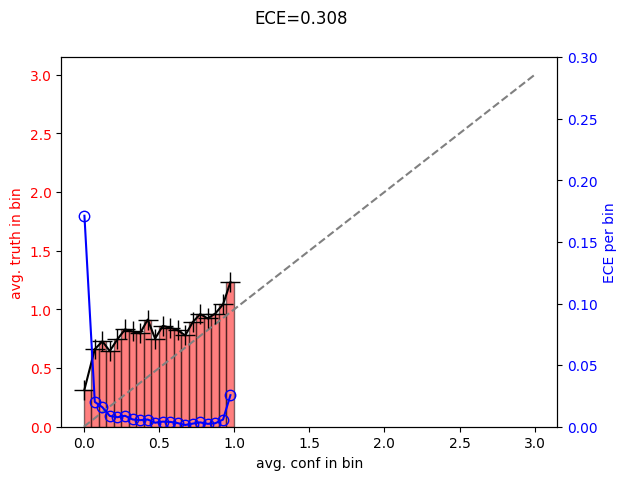

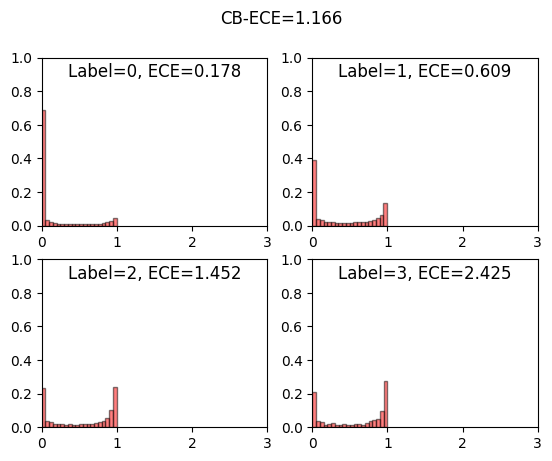

In [7]:
results_path = "../pygaggle/calibration-exp/scores/monot5-base-msmarco-10k/marcov2-results.trec.pkl"
results = pickle.load(open(results_path, "rb"))
calculate_metrics(results, trec22_qrels)